In [2]:
import os
import pickle
from typing import List, Tuple, Optional

import cartopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from src import configure, best_track, plotting

In [3]:
config = configure.get_config()
configure.configure_ipython()
plotting.configure_figures()

In [4]:
#TODO:
# - clean up plotting.py
#

## Datasets

### Drifters and Submersibles

In [5]:
def read_drifter_dataset(path: str) -> pd.DataFrame:
    with open(path, 'rb') as handle:
        drifter_data = pickle.load(handle)

    # Concatenate the individual drifter DataFrames by type
    microswift_df = concatenate_drifters(drifter_data['microswift'])
    spotter_df = concatenate_drifters(drifter_data['spotter'])
    dwsd_df = concatenate_drifters(drifter_data['dwsd'])

    # Create a drifter type column
    microswift_df['drifter_type'] = 'microswift'
    spotter_df['drifter_type'] = 'spotter'
    dwsd_df['drifter_type'] = 'dwsd'

    # Combine all drifters into a single DataFrame.
    drifter_df = (pd.concat([microswift_df, spotter_df, dwsd_df])
                .sort_index(level=['id', 'time'], ascending=True))
    # .loc[(slice(None), time_slice), :]
    return drifter_df


def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).

    Args:
        drifter_dict (dict): individual drifter DataFrames keyed by id.

    Returns:
        DataFrame: concatenated drifters
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

In [6]:
ian_drifter_df = read_drifter_dataset(config['dir']['ian_drifter_data'])
lee_drifter_df = read_drifter_dataset(config['dir']['lee_drifter_data'])
idalia_drifter_df = read_drifter_dataset(config['dir']['idalia_drifter_data'])
francine_drifter_df = read_drifter_dataset(config['dir']['francine_drifter_data'])
helene_drifter_df = read_drifter_dataset(config['dir']['helene_drifter_data'])
milton_drifter_df = read_drifter_dataset(config['dir']['milton_drifter_data'])

In [7]:
import geopandas as gpd
from fiona.drvsupport import supported_drivers

def read_kml_file(path: str) -> gpd.GeoDataFrame:
    """ Read a KML file (.kml) into a GeoDataFrame.

    Read a KML file (.kml) into a GeoDataFrame.  The output coordinate
    reference system (crs) will be the same as what is specified in the KML.

    Args:
        path (str): path to the KML file.

    Returns:
        gpd.GeoDataFrame: KML file data.
    """
    # Enable fiona driver
    supported_drivers['LIBKML'] = 'rw'
    return gpd.read_file(path, driver='LIBKML')

In [8]:
francine_submersible_gdf = read_kml_file(config['dir']['francine_submersibles_kml'])
helene_submersible_gdf = best_track.read_kml_file(config['dir']['helene_submersibles_kml'])
milton_submersible_gdf = best_track.read_kml_file(config['dir']['milton_submersibles_kml'])

/opt/homebrew/Caskroom/miniconda/base/envs/ocean-surface-wave-slopes-and-wind-wave-alignment/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/homebrew/Caskroom/miniconda/base/envs/ocean-surface-wave-slopes-and-wind-wave-alignment/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/homebrew/Caskroom/miniconda/base/envs/ocean-surface-wave-slopes-and-wind-wave-alignment/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch ex

### Water level sensors

In [9]:
# Task 3B sensor locations.
water_level_sensor_df = pd.read_csv(
    config['dir']['water_level_sensors'],
)

# Separate the year and storm name, and set latter as the index.
water_level_sensor_df[['Year', 'Storm']] \
    = water_level_sensor_df['Storm'].str.split(' ', expand=True)
water_level_sensor_df = water_level_sensor_df.set_index('Storm')

### Best Track

In [10]:
def read_nhc_best_track(directory: str) -> Tuple:
    directory_norm = os.path.normpath(directory)
    best_track_folder_name = os.path.split(directory_norm)[-1]
    storm_id = best_track_folder_name.split('_')[0]
    storm_id = storm_id.upper()
    nhc_pts = best_track.read_shp_file(directory + f'{storm_id}_pts.shp', index_by_datetime=True)
    nhc_lin = best_track.read_shp_file(directory + f'{storm_id}_lin.shp')
    nhc_radii = best_track.read_shp_file(directory + f'{storm_id}_radii.shp')
    nhc_windswath = best_track.read_shp_file(directory + f'{storm_id}_windswath.shp')
    nhc_pts = best_track.best_track_pts_to_intensity(nhc_pts)
    return (nhc_pts, nhc_lin, nhc_windswath)

In [11]:
ian_best_track = read_nhc_best_track(config['dir']['ian_best_track'])
lee_best_track = read_nhc_best_track(config['dir']['lee_best_track'])
idalia_best_track = read_nhc_best_track(config['dir']['idalia_best_track'])
francine_best_track = read_nhc_best_track(config['dir']['francine_best_track'])
helene_best_track = read_nhc_best_track(config['dir']['helene_best_track'])
milton_best_track = read_nhc_best_track(config['dir']['milton_best_track'])

### IBTrACS

In [12]:
IBTRACS_PATH = config['dir']['ibtracs']
storm_names = ["IAN", "IDALIA", "LEE", "FRANCINE", "HELENE", "MILTON"]
ibtracs_df = pd.read_csv(IBTRACS_PATH, low_memory=False)
ibtracs_df = (ibtracs_df
    .query(f'NAME == {storm_names}')
    # .query('SEASON == "2023"')
    # .query('BASIN == "NA"')
    .query('SEASON == ["2022", "2023", "2024"]')
    .assign(ISO_TIME = lambda df: pd.to_datetime(df['ISO_TIME'], utc=True))
    .set_index(['NAME', 'ISO_TIME'], drop=True)
    # .set_index('ISO_TIME', drop=True)
    .assign(LAT = lambda df: df['LAT'].astype(np.float64))
    .assign(LON = lambda df: df['LON'].astype(np.float64))
)

In [13]:
# ibtracs_upsampled_positions_df = ibtracs_df.loc[:, ['LAT', 'LON']].resample('1h').interpolate(method='linear')
# ibtracs_upsampled_intensities_df = ibtracs_df.loc[:, ['USA_SSHS']].resample('1h').ffill()
# ibtracs_upsampled_df = pd.concat(
#     [ibtracs_upsampled_positions_df, ibtracs_upsampled_intensities_df],
#      axis=1,
# )

#TODO: clean up, kind of crude.
ibtracs_grouped = ibtracs_df.groupby(
    by='NAME',
    as_index=True,
    group_keys=True
)
ibtracs_upsampled_positions_df = ibtracs_grouped.apply(
    lambda df: (
        df
        .droplevel('NAME')
        .loc[:, ['LAT', 'LON']]
        .resample('1h')
        .interpolate(method='linear')
    )
)
ibtracs_upsampled_intensities_df = ibtracs_grouped.apply(
    lambda df: (
        df
        .droplevel('NAME')
        .loc[:, ['USA_SSHS']]
        .resample('1h')
        .ffill()
    )
)
ibtracs_upsampled_df = pd.concat(
    [ibtracs_upsampled_positions_df, ibtracs_upsampled_intensities_df],
     axis=1,
)

### GEBCO bathymetry

In [14]:
ian_bathymetry_ds = xr.open_dataset(config['dir']['ian_bathymetry'])
idalia_bathymetry_ds = xr.open_dataset(config['dir']['idalia_bathymetry'])
lee_bathymetry_ds = xr.open_dataset(config['dir']['lee_bathymetry'])
francine_bathymetry_ds = xr.open_dataset(config['dir']['francine_bathymetry'])
helene_bathymetry_ds = xr.open_dataset(config['dir']['helene_bathymetry'])
milton_bathymetry_ds = xr.open_dataset(config['dir']['milton_bathymetry'])

## Maps

In [15]:
# TODO:
# - Central legend for all plots
# - Scale bars
# - Bathy labels

In [16]:
def get_drifter_type_df(drifter_df, drifter_type):
    """ Return a DataFrame containing only the specified drifter type. """
    is_drifter_type = drifter_df['drifter_type'] == drifter_type
    return drifter_df.loc[is_drifter_type, :]

In [86]:
#TODO: rename?
def plot_overview_map_bathy(
    ax,
    hour_to_display: pd.Timestamp,
    drifter_df: pd.DataFrame,
    water_level_sensor_df: pd.DataFrame,
    bathymetry_ds,
    nhc_best_track: Tuple,
    ibtracs_df: pd.DataFrame,
    extent: List,
    extent_minimap: List,
    submersible_gdf: Optional[gpd.GeoDataFrame] = None,
    minimap_loc='upper right',
    bathymetry_kwargs=None,
    gridline_kwargs=None,
    annotate_drifters=False,
):
    # Create time slices.
    display_time_slice = slice(hour_to_display,
                               hour_to_display + pd.Timedelta('1hour'))
    up_to_display_time_slice = slice(None, hour_to_display + pd.Timedelta('1hour'))
    past_display_time_slice = slice(hour_to_display, None)
    up_to_display_line_kwargs = {'linewidth': 0.4, 'color': 'k', 'linestyle': '-'}
    past_display_line_kwargs = {'linewidth': 0.4, 'color': 'k', 'linestyle': '--', 'dashes': (2, 2)}

    land_kwargs = {'color': 'papayawhip', 'alpha': 1.0, 'zorder': 0}
    ocean_kwargs = {'color': np.array([150, 183, 206])/255}
    annotation_kwargs = dict(ha = 'center', va = 'bottom', fontsize = 10)

    # Set the aspect ratio of the map
    # plotting.set_sq_map_aspect(ax, extent)
    # ax.set_adjustable('box')

    # ax.set_aspect('auto', adjustable='datalim')

    # Plot the base Cartopy map
    if gridline_kwargs is None:
        gridline_kwargs = {}

    #TODO: change base_chart kwarg defaults to None and fill in after
    plotting.plot_base_chart(
        ax,
        extent,
        land_kwargs=land_kwargs,
        ocean_kwargs=ocean_kwargs,
        gridline_kwargs=gridline_kwargs,
    )

    # Plot bathymetry.
    if bathymetry_kwargs is None:
        bathymetry_kwargs = dict(
            levels = [-100, -80, -60, -50, -40, -30, -20, -10, 0],
            label_levels = None,
            label_locations = None,
            angle = 0,
        )

    bathy_plot = plotting.plot_bathymetry(
        bathymetry_ds,
        levels=bathymetry_kwargs['levels'],
        ax=ax,
        **plotting.bathy_plot_kwargs
    )
    bathy_contours, bathy_labels = plotting.plot_bathymetry_contours(
        bathymetry_ds,
        label_levels=bathymetry_kwargs['label_levels'],
        label_locations=bathymetry_kwargs['label_locations'],
        angle=bathymetry_kwargs['angle'],
        fontsize=6.5,
        ax=ax,
        **plotting.bathy_contour_kwargs,
    )

    # Plot and annotate drifters
    spotter_df = get_drifter_type_df(drifter_df, 'spotter')
    microswift_df = get_drifter_type_df(drifter_df, 'microswift')
    dwsd_df = get_drifter_type_df(drifter_df, 'dwsd')

    drifter_handles = []
    if spotter_df is not None:
        for drifter_id in spotter_df.index.get_level_values('id'):
            plotting.plot_drifter_track_line(
                spotter_df.loc[(drifter_id, up_to_display_time_slice), :],
                ax,
                **up_to_display_line_kwargs,
            )
            plotting.plot_drifter_track_line(
                spotter_df.loc[(drifter_id, past_display_time_slice), :],
                ax,
                **past_display_line_kwargs,
            )
        spotter_plot = plotting.plot_drifter_track(
            spotter_df.xs(display_time_slice, level='time'),
            ax,
            label=plotting.get_drifter_label('spotter'),
            **plotting.spotter_map_kwargs,
        )
        drifter_handles.append(spotter_plot)
        if annotate_drifters:
            spotter_ann = plotting.annotate_drifter(
                spotter_df.xs(display_time_slice, level='time'),
                ax,
                **annotation_kwargs
            )
    else:
        drifter_handles.append(plotting.get_empty_legend_placeholder())

    if microswift_df is not None:
        for drifter_id in microswift_df.index.get_level_values('id'):
            plotting.plot_drifter_track_line(
                microswift_df.loc[(drifter_id, up_to_display_time_slice), :],
                ax,
                **up_to_display_line_kwargs,
            )
            plotting.plot_drifter_track_line(
                microswift_df.loc[(drifter_id, past_display_time_slice), :],
                ax,
                **past_display_line_kwargs,
            )
        microswift_plot = plotting.plot_drifter_track(
            microswift_df.xs(display_time_slice, level='time'),
            ax,
            label=plotting.get_drifter_label('microswift'),
            **plotting.microswift_map_kwargs,
        )
        drifter_handles.append(microswift_plot)
        if annotate_drifters:
            microswift_ann = plotting.annotate_drifter(
                microswift_df.xs(display_time_slice, level='time'),
                ax,
                **annotation_kwargs
            )
    else:
        drifter_handles.append(plotting.get_empty_legend_placeholder())

    if dwsd_df is not None:
        for drifter_id in dwsd_df.index.get_level_values('id'):
            plotting.plot_drifter_track_line(
                dwsd_df.loc[(drifter_id, up_to_display_time_slice), :],
                ax,
                **up_to_display_line_kwargs,
            )
            plotting.plot_drifter_track_line(
                dwsd_df.loc[(drifter_id, past_display_time_slice), :],
                ax,
                **past_display_line_kwargs,
            )
        dwsd_plot = plotting.plot_drifter_track(
            dwsd_df.xs(display_time_slice, level='time'),
            ax,
            label=plotting.get_drifter_label('dwsd'),
            **plotting.dwsd_map_kwargs,
        )
        drifter_handles.append(dwsd_plot)
        if annotate_drifters:
            dwsd_ann = plotting.annotate_drifter(
                dwsd_df.xs(display_time_slice, level='time'),
                ax,
                **annotation_kwargs
            )
    else:
        drifter_handles.append(plotting.get_empty_legend_placeholder())

    # Plot submersibles
    if submersible_gdf is not None:
        submersible_plot = submersible_gdf.plot(ax=ax, **plotting.submersible_map_kwargs)

    # Plot water level sensors
    if water_level_sensor_df is not None:
        plotting.plot_water_level_sensors(
            water_level_sensor_df,
            ax=ax,
            **plotting.water_level_sensor_map_kwargs,
        )

    # Plot ibtracs
    ax.plot(
        ibtracs_df['LON'],
        ibtracs_df['LAT'],
        color='k',
        alpha=1,
    )

    # Plot the storm center
    storm_longitude = ibtracs_df.loc[display_time_slice, 'LON'].mean()
    storm_latitude = ibtracs_df.loc[display_time_slice, 'LAT'].mean()
    plotting.plot_hurricane_symbol(
        ax,
        xy=(storm_longitude, storm_latitude),
        annotation_bbox_kwargs={'zorder': 5, 'clip_on': True},
    )

    # Plot best track shapefiles (pass None for lin since ibtracs is used).
    pts_kwargs = {'markersize': 125}
    plotting.plot_best_track(ax, nhc_best_track[0], None, nhc_best_track[2], pts_kwargs=pts_kwargs)

    # Create a minimap for context
    #TODO: clean up
    dx_extent = extent[1] - extent[0]
    dx_extent_minimap = extent_minimap[1] - extent_minimap[0]
    dy_extent = extent[3] - extent[2]
    dy_extent_minimap = extent_minimap[3] - extent_minimap[2]
    xy_ratio_minimap = dx_extent_minimap/dy_extent_minimap
    xy_ratio = dx_extent/dy_extent

    height_minimap = 30
    width_minimap = height_minimap * xy_ratio_minimap/xy_ratio

    inset_axes_kwargs = {
        'width': f'{width_minimap}%',
        'height': f'{height_minimap}%',
        'loc': minimap_loc,
    }
    ax_inset = plotting.plot_minimap(
        ax,
        extent=extent_minimap,
        inset_axes_kwargs=inset_axes_kwargs,
        land_kwargs=land_kwargs,
        ocean_kwargs=ocean_kwargs
    )

    # Plot minimap best track
    pts_kwargs = {'markersize': 75}
    annotate_pts_kwargs = {'fontsize': 6}
    plotting.plot_best_track(ax_inset, *nhc_best_track, pts_kwargs=pts_kwargs, annotate_pts_kwargs=annotate_pts_kwargs)

    # Add the inset rectangle to the main map
    ax_inset.add_patch(mpl.patches.Rectangle(
        xy=[extent[0], extent[2]],
        width= extent[1] - extent[0],
        height= extent[3] - extent[2],
        facecolor='none',
        edgecolor='k',
        linewidth=0.5,
        alpha=1,
        zorder=4,
        )
    )
    ax_inset.set_aspect('equal')
    # plotting.set_sq_map_aspect(ax, extent_minimap)

    # Create a custom legend representing the windswath geometries
    if submersible_gdf is not None:
        first_legend_entry = mpl.lines.Line2D([0], [0], marker='o', label='submersible', color='none', markerfacecolor=plotting.submersible_map_kwargs['color'], markersize=np.sqrt(plotting.submersible_map_kwargs['markersize']), markeredgewidth=plotting.submersible_map_kwargs['linewidth'])
    else:
        first_legend_entry = mpl.patches.Patch(label='', facecolor='none')

    legend_elements = [
       first_legend_entry,
        mpl.patches.Patch(label='34 kt windswath', facecolor='lightgrey', alpha = 0.5, edgecolor='none'),
        mpl.patches.Patch(label='50 kt windswath', facecolor='darkgrey', alpha = 0.5, edgecolor='none'),
        mpl.patches.Patch(label='64 kt windswath', facecolor='dimgrey', alpha = 0.5, edgecolor='none'),
    ]

    ax.legend(
        handles=[*drifter_handles, *legend_elements],
        loc='lower left',
        edgecolor='none',
        ncols=2,
        bbox_to_anchor=(-0, 1),
        frameon=False,
        borderpad=0.1,
    ).set_zorder(10)

    ax.set_aspect('equal')#, adjustable='box')


### Ian (2022)

d_latitude: 6.0
aspect: 1.0


Text(1.0, 1.0, '28 Sep 09:00Z')

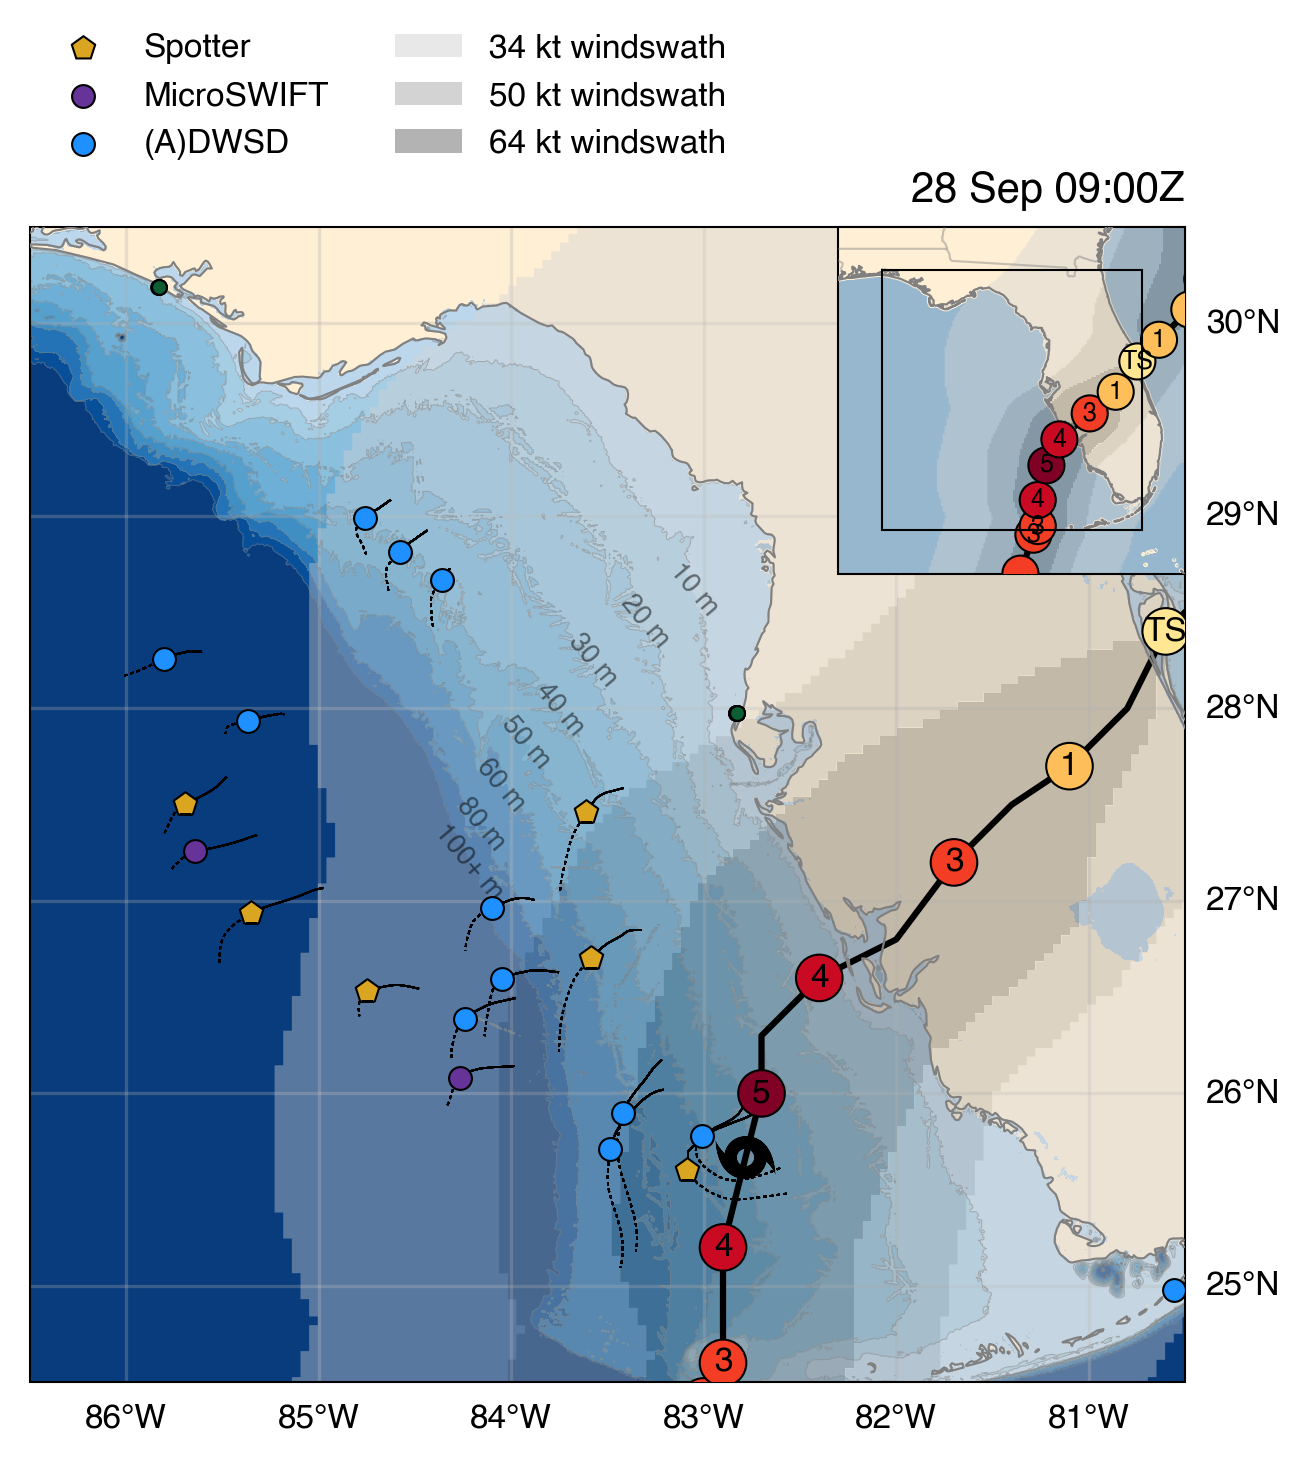

In [87]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2022-09-28T09:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('12h'),
                   hour_to_display + pd.Timedelta('12h'))
extent = [-86.5, -80.5, 24.5, 30.5]
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])  # [-88, -80, 23, 30.5]
bathymetry_kwargs = dict(
    levels = [-100, -80, -60, -50, -40, -30, -20, -10, 0],
    label_levels = [-100, -80, -60, -50, -40, -30, -20, -10],
    label_locations = [
        (-84.4, 27.12),
        (-84.15, 27.40),
        (-84.10, 27.55),
        (-83.95, 27.80),
        (-83.75, 28),
        (-83.5, 28.25),
        (-83.25, 28.5),
        (-83.0, 28.65),
    ],
    angle = -50,
)

print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=ian_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=water_level_sensor_df.loc['Ian', :],
    nhc_best_track=ian_best_track,
    bathymetry_ds=ian_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['IAN'],
    extent=extent,
    extent_minimap=extent_minimap,
    bathymetry_kwargs=bathymetry_kwargs,
)

ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')
# fig.savefig('ian_map.png',  bbox_inches='tight')

### Idalia (2023)

d_latitude: 6.0
aspect: 1.0


Text(1.0, 1.0, '30 Aug 08:00Z')

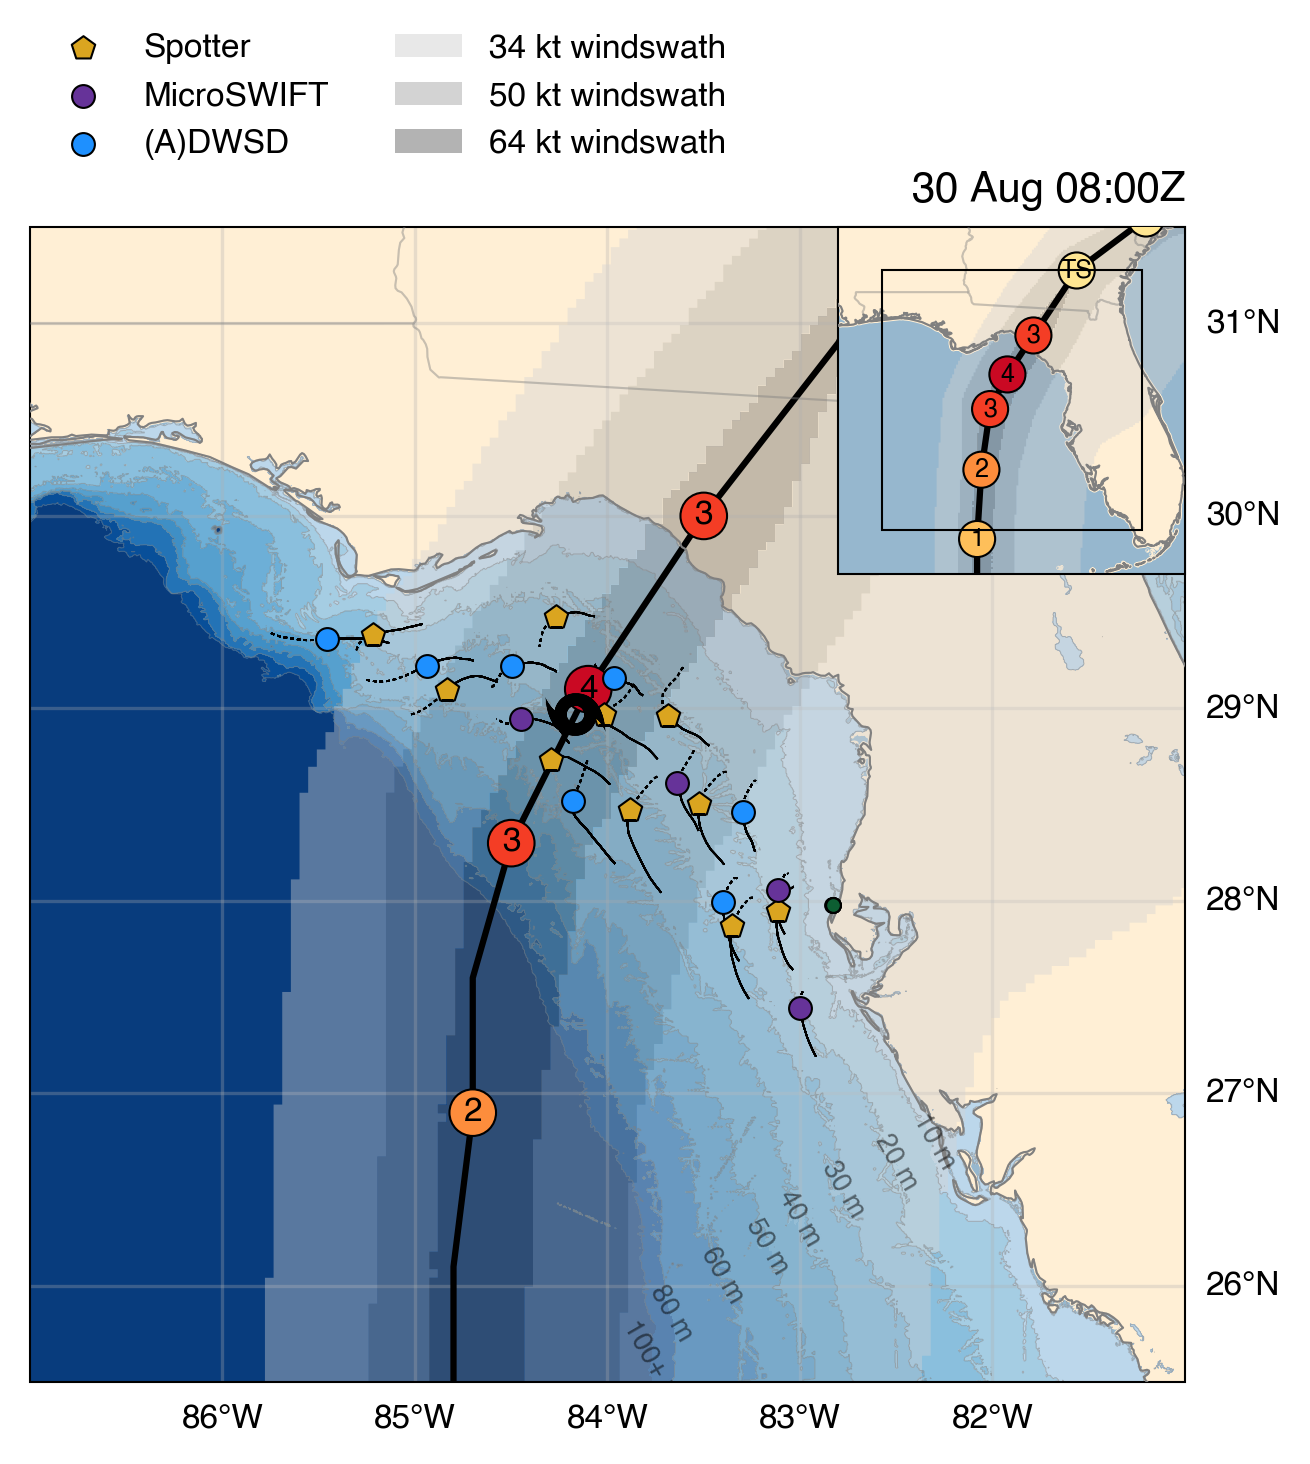

In [83]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2023-08-30T08:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('8h'),
                   hour_to_display + pd.Timedelta('8h'))

# extent = plotting.sq_aspect_map_extent_from_longitude(
#     lower_latitude=26.5,
#     upper_latitude=30.5,
#     center_longitude=np.mean([-86.5, -81.5]),
# )

extent = [-87, -81, 25.5, 31.5]
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])  # [-88, -80, 24.5, 32.5]
bathymetry_kwargs = dict(
    levels = [-100, -80, -60, -50, -40, -30, -20, -10, 0],
    label_levels = [-100, -80, -60, -50, -40, -30, -20, -10],
    label_locations = [
        (-83.75, 25.60),
        (-83.58, 25.90),
        (-83.4, 26.05),
        (-83.17, 26.20),
        (-83.0, 26.35),
        (-82.75, 26.5),
        (-82.5, 26.65),
        (-82.3, 26.75),
    ],
    angle = -60,
)

print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')


fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=idalia_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=water_level_sensor_df.loc['Idalia', :],
    nhc_best_track=idalia_best_track,
    bathymetry_ds=idalia_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['IDALIA'],
    extent=extent,
    extent_minimap=extent_minimap,
    bathymetry_kwargs=bathymetry_kwargs,
    # gridline_kwargs = {
    #     'xlocs': [-86, -85, -84, -83, -82, -81],
    #     'ylocs': [27, 28, 29, 30],
    # },
)

ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')
# fig.savefig('idalia_map.png',  bbox_inches='tight')

### Lee (2023)

d_latitude: 7.0
aspect: 1.0


Text(1.0, 1.0, '16 Sep 09:00Z')

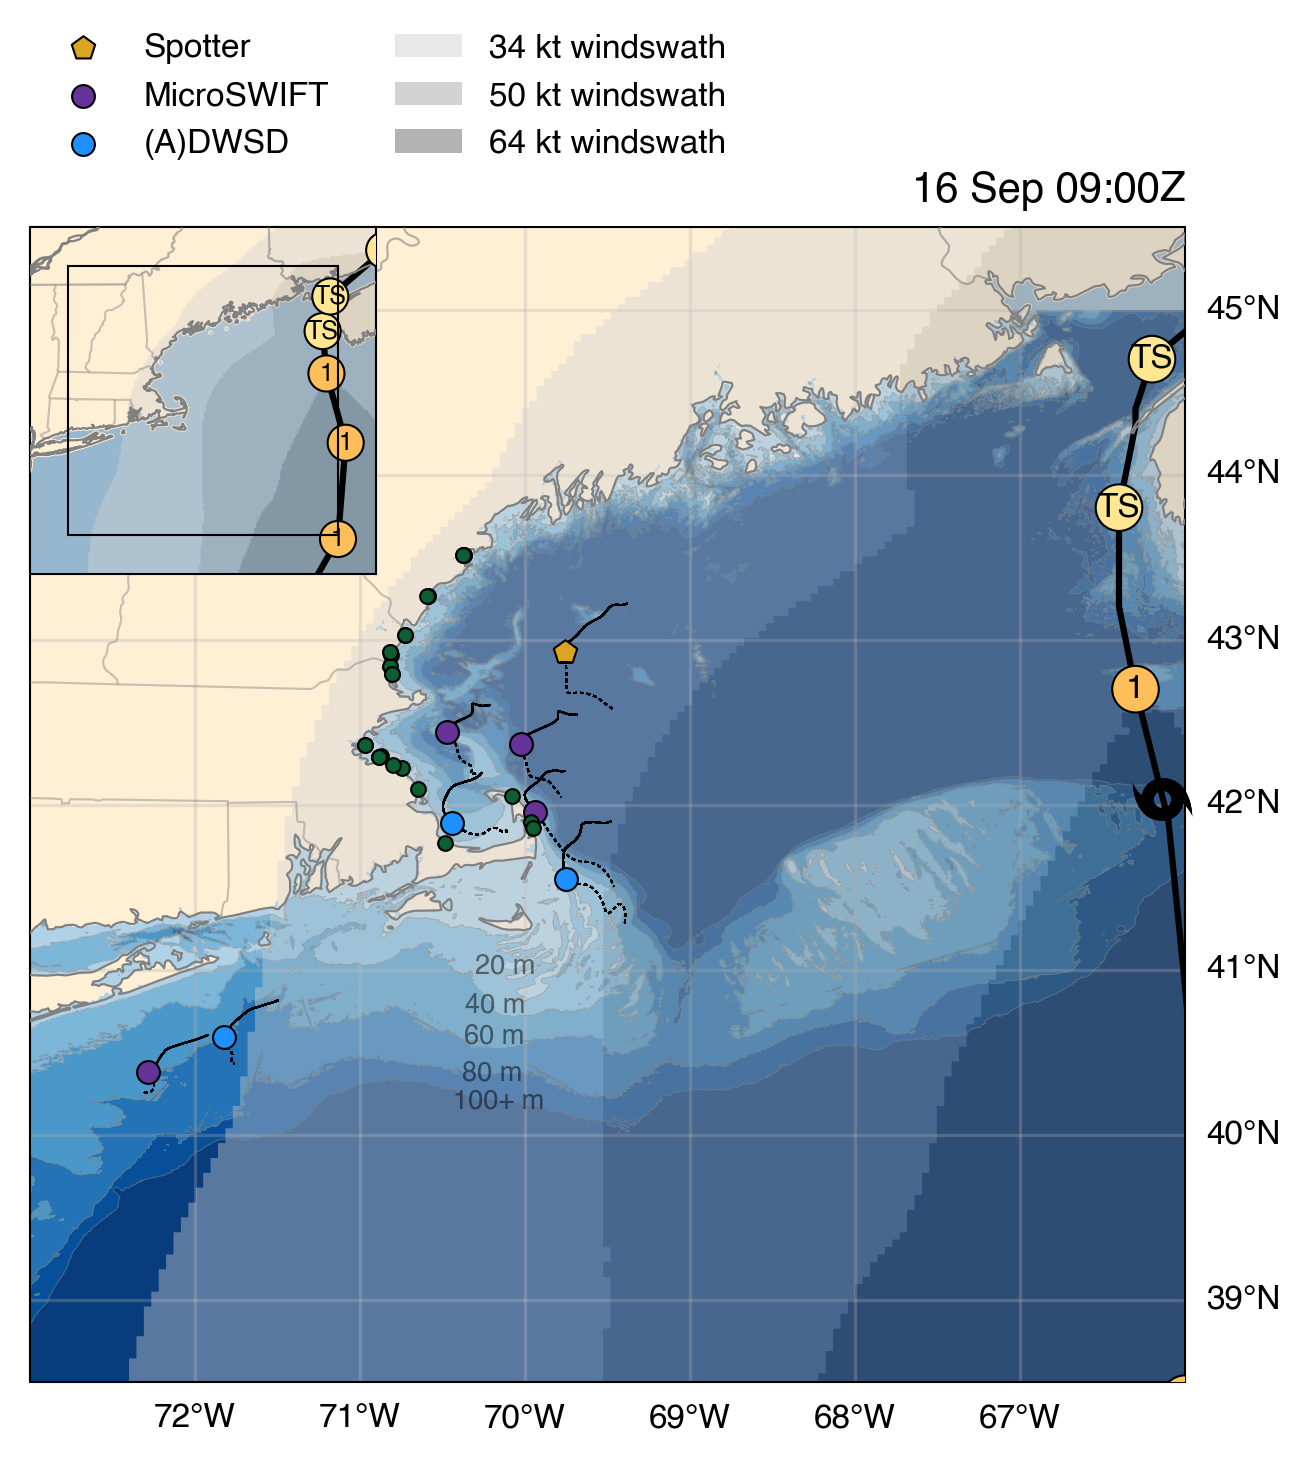

In [99]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2023-09-16T09:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('24h'),
                   hour_to_display + pd.Timedelta('24h'))

# extent = plotting.sq_aspect_map_extent_from_longitude(
#     lower_latitude=38,
#     upper_latitude=45,
#     center_longitude=np.mean([-75, -65]),
# )

extent = np.array([-73, -66, 38.5, 45.5])
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])  # [-75, -62, 36, 47]
bathymetry_kwargs = dict(
    levels = [-100, -80, -60, -40, -20, 0],
    label_levels = [-100, -80, -60, -40, -20],
    label_locations = [
        (-70.2, 40.10),
        (-70.2, 40.40),
        (-70.2, 40.57),
        (-70.15, 40.82),
        (-70.2, 40.98),
    ],
    angle = 0,
)

print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')



fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)

plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=lee_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=water_level_sensor_df.loc['Lee', :],
    nhc_best_track=lee_best_track,
    bathymetry_ds=lee_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['LEE'],
    extent=extent,  # [-75, -65, 38, 45],
    # extent= [-80, -60, 29, 46.5],
    extent_minimap=extent_minimap, # [-80, -60, 30, 47],
    minimap_loc='upper left',
    bathymetry_kwargs=bathymetry_kwargs,
)
ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')
# fig.savefig('lee_map.png',  bbox_inches='tight')

### Francine (2024)

d_latitude: 6.0
aspect: 1.0


Text(1.0, 1.0, '11 Sep 17:00Z')

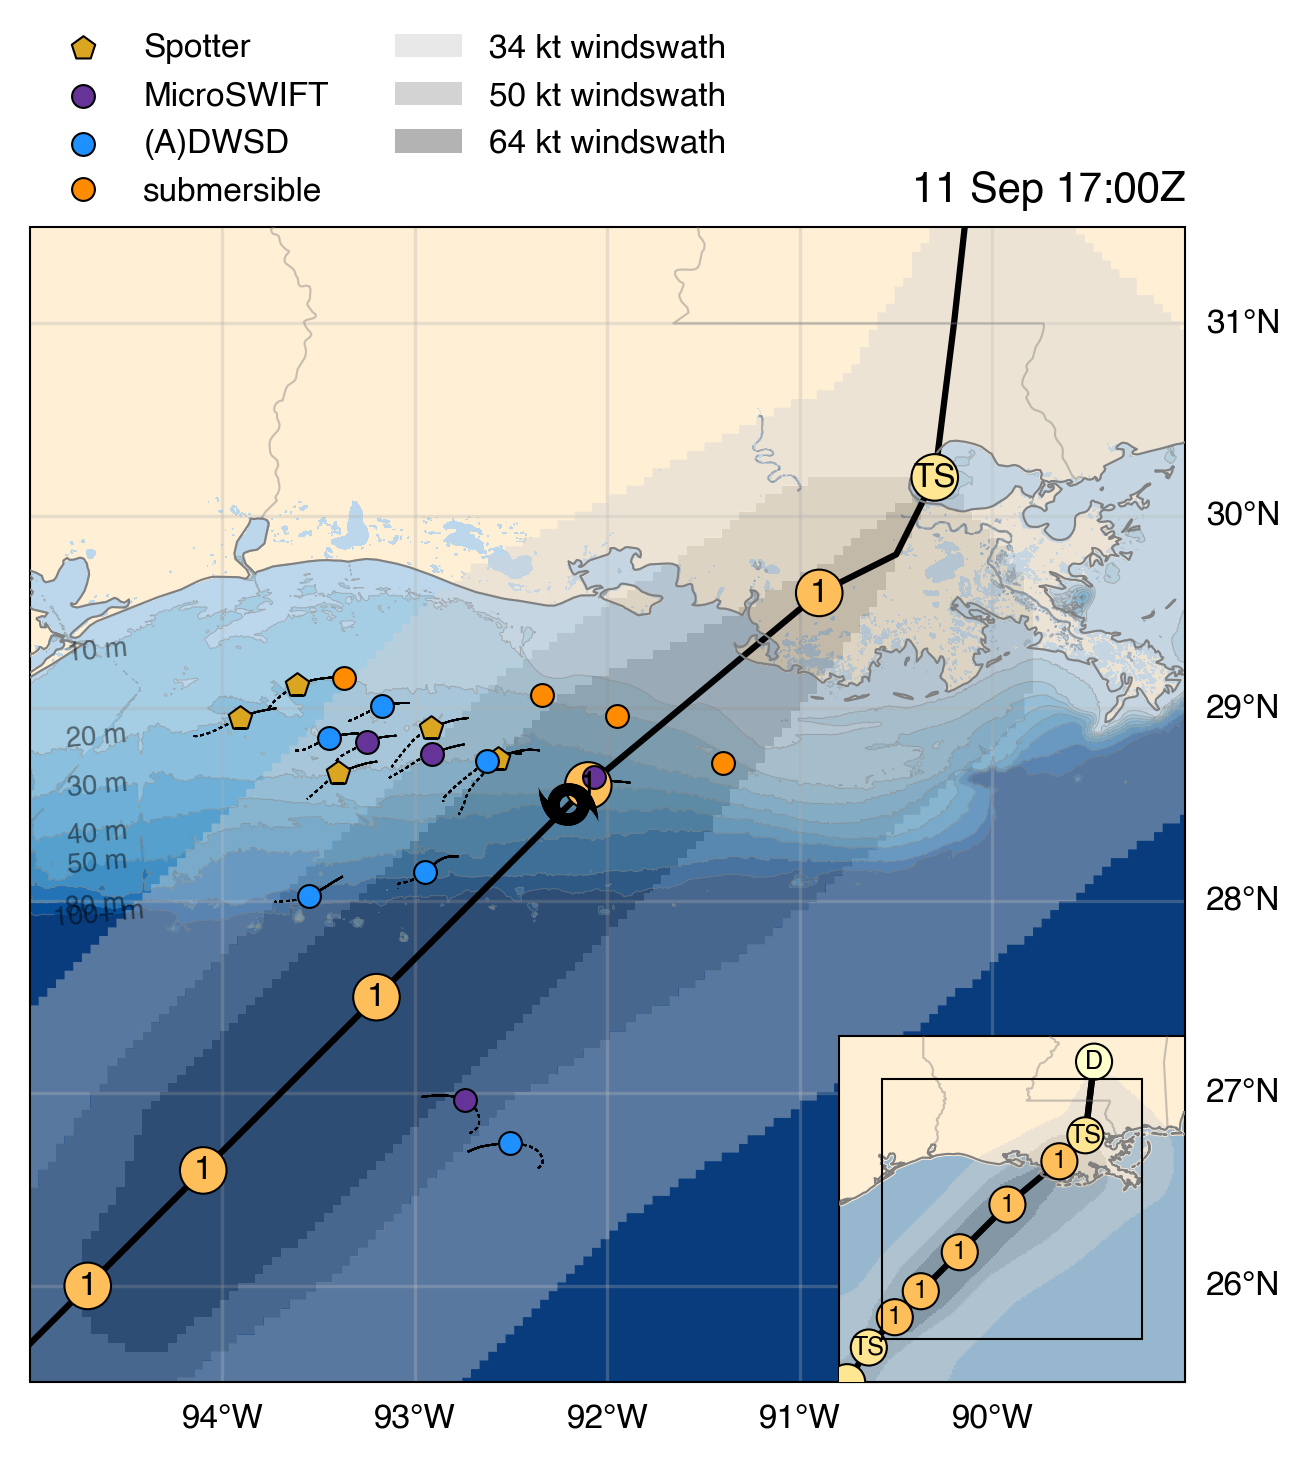

In [106]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2024-09-11T17:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('4h'),
                   hour_to_display + pd.Timedelta('10h'))

extent = np.array([-95, -89, 25.5, 31.5])
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])  # [-75, -62, 36, 47]
bathymetry_kwargs = dict(
    levels = [-100, -80, -60, -50, -40, -30, -20, -10, 0],
    label_levels = [-100, -80, -60, -50, -40, -30, -20, -10],
    label_locations = [
        (-94.65, 27.9),
        (-94.65, 28.0),
        (-94.65, 28.2),
        (-94.65, 28.3),
        (-94.65, 28.6),
        (-94.65, 28.85),
        (-94.65, 29.3),
    ],
    angle = 5,
)


print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')


fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)

plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=francine_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=None,
    nhc_best_track=francine_best_track,
    bathymetry_ds=francine_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['FRANCINE'],
    extent=extent, # [-95, -89, 25.5, 31],
    extent_minimap=extent_minimap,  #[-98, -87, 24.5, 32.5],
    minimap_loc='lower right',
    submersible_gdf=francine_submersible_gdf,
    bathymetry_kwargs=bathymetry_kwargs,
    # gridline_kwargs = {
    #     'xlocs': [-86, -85, -84, -83, -82, -81],
    #     'ylocs': [27, 28, 29, 30],
    # },
)

ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')

# fig.savefig('francine_map.png',  bbox_inches='tight')

### Helene (2024)

d_latitude: 6.0
aspect: 1.0


Text(1.0, 1.0, '27 Sep 00:00Z')

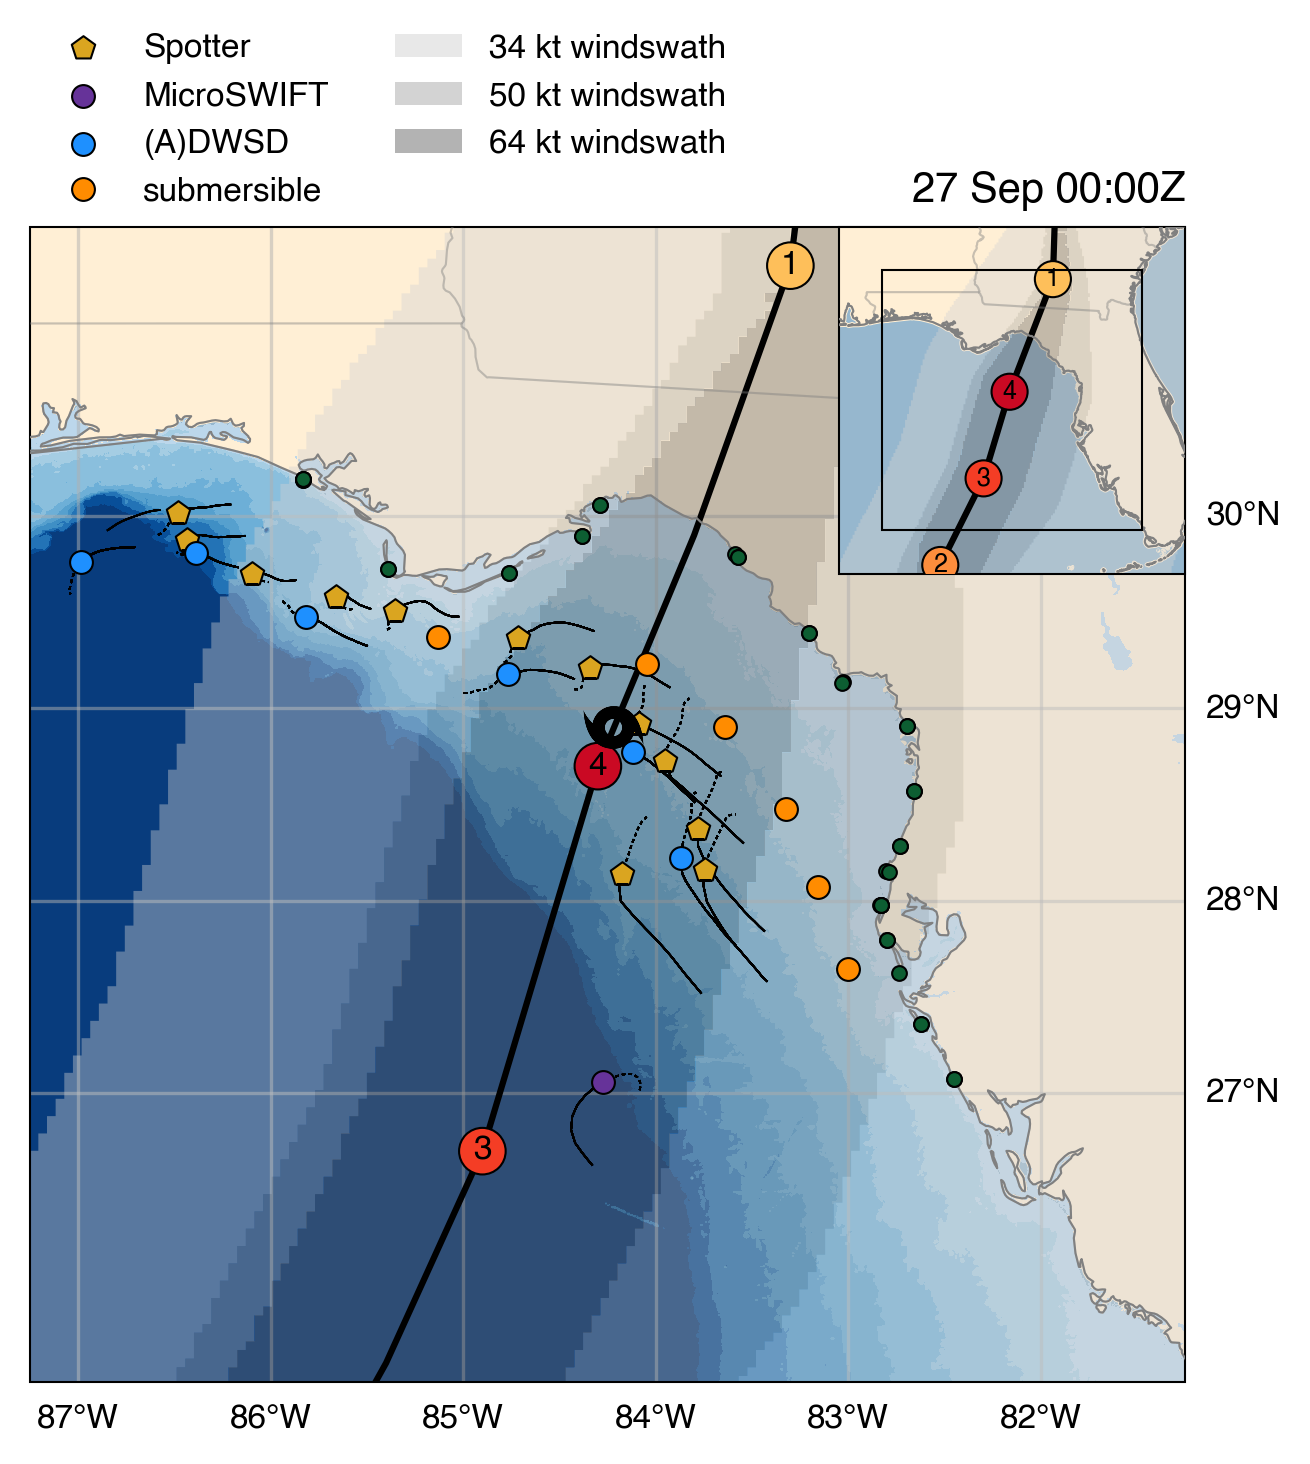

In [216]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2024-09-27T00:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('12h'),
                   hour_to_display + pd.Timedelta('12h'))

extent = [-87.25, -81.25, 25.5, 31.5]
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])

print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')


fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)

plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=helene_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=water_level_sensor_df.loc['Helene', :],
    nhc_best_track=helene_best_track,
    bathymetry_ds=helene_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['HELENE'],
    extent=extent,  #[-87.5, -81.5, 26.0, 30.5],
    extent_minimap=extent_minimap,  #[-89, -79, 24.25, 32.5],
    submersible_gdf=helene_submersible_gdf,
    gridline_kwargs = {
        'xlocs': [-87, -86, -85, -84, -83, -82],
        'ylocs': [27, 28, 29, 30],
    },
)

ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')

# fig.savefig('helene_map.png',  bbox_inches='tight')

### Milton (2024)

d_latitude: 6.0
aspect: 1.0


Text(1.0, 1.0, '09 Oct 20:00Z')

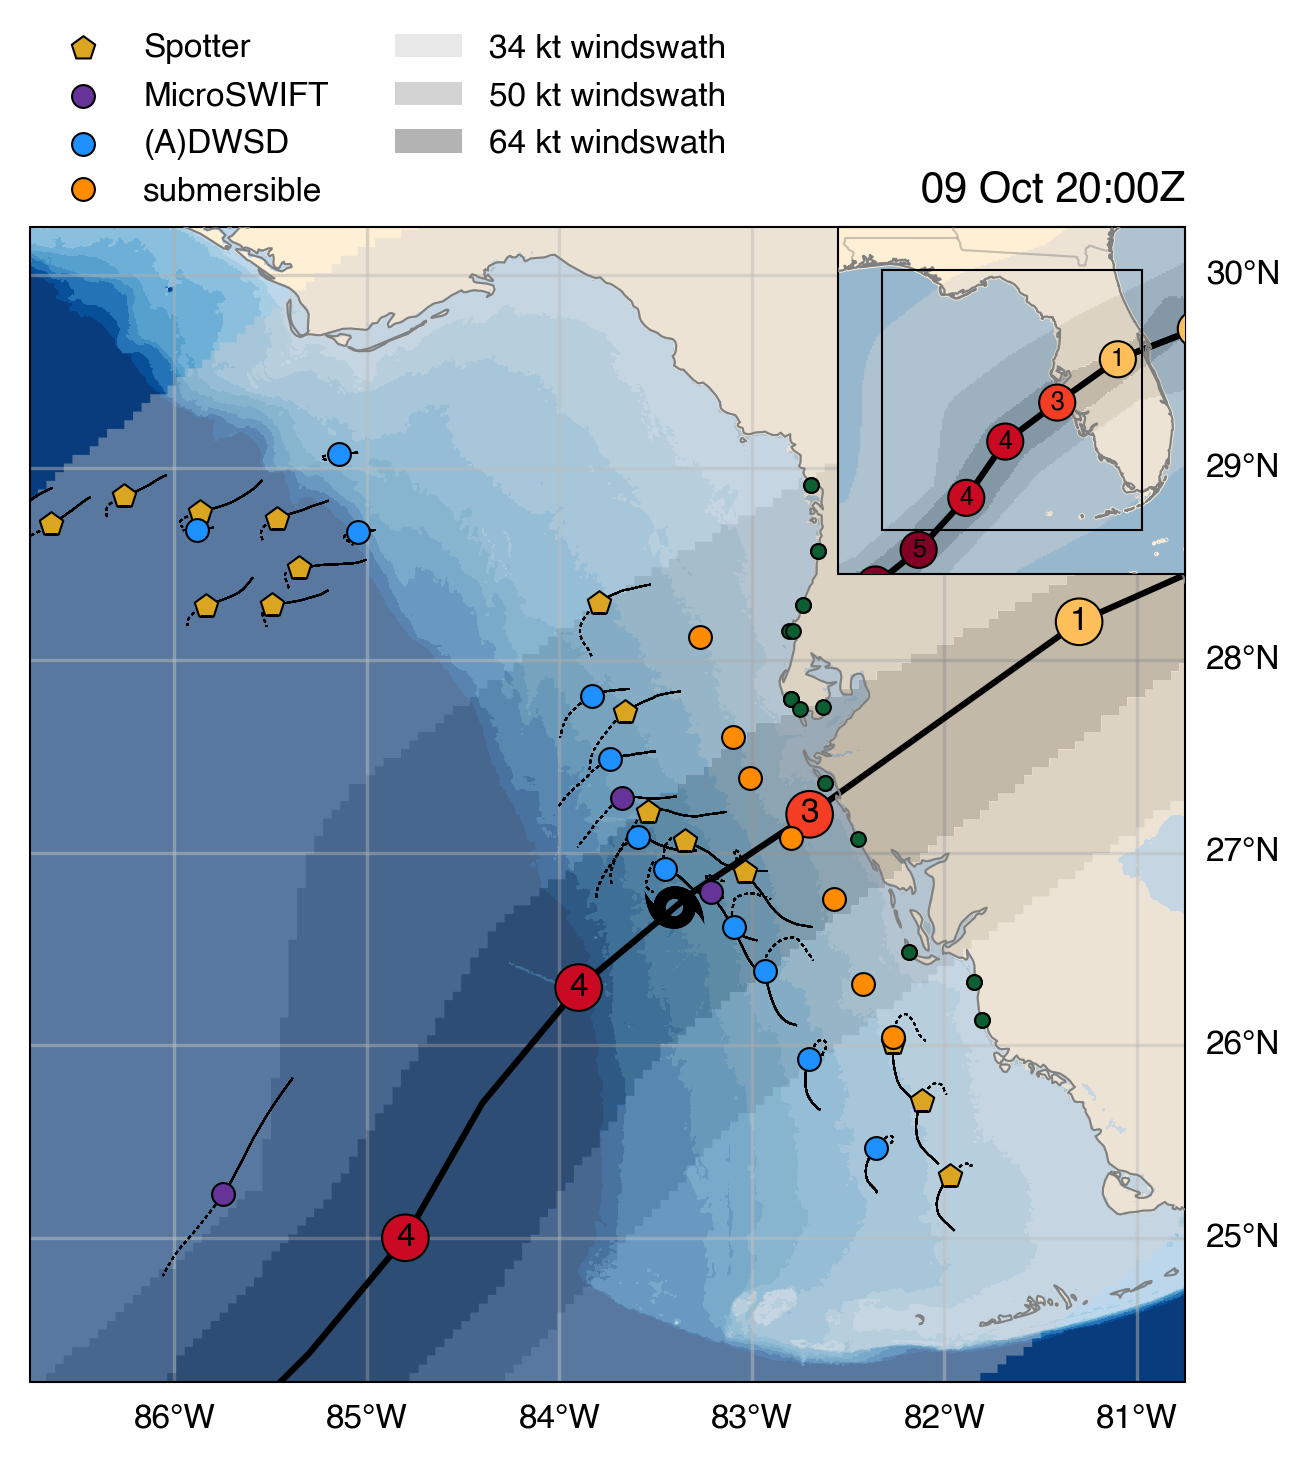

In [223]:
FIG_SIZE = (5.5, 5)
CRS = cartopy.crs.PlateCarree()

# Plot the map when the buoys are near the storm center.
hour_to_display = pd.Timestamp('2024-10-09 20:00', tz='UTC')
time_slice = slice(hour_to_display - pd.Timedelta('12h'),
                   hour_to_display + pd.Timedelta('12h'))

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)


extent = [-86.75, -80.75, 24.25, 30.25]
extent_minimap = extent + 1 * np.array([-1, 1, -1, 1])

print(f'd_latitude: {extent[3] - extent[2]}')
print(f'aspect: {(extent[1] - extent[0]) / (extent[3] - extent[2])}')


plot_overview_map_bathy(
    ax,
    hour_to_display=hour_to_display,
    drifter_df=milton_drifter_df.loc[(slice(None), time_slice), :],
    water_level_sensor_df=water_level_sensor_df.loc['Milton', :],
    nhc_best_track=milton_best_track,
    bathymetry_ds=milton_bathymetry_ds,
    ibtracs_df=ibtracs_upsampled_df.loc['MILTON'],
    submersible_gdf=milton_submersible_gdf,
    extent=extent,  #[-86.5, -81, 24.5, 29.5],
    extent_minimap=extent_minimap,  #[-88, -80, 23, 30.5],
)

ax.set_title(f"{hour_to_display.strftime('%d %b %H:%MZ')}", loc='right')

# fig.savefig('milton_map.png',  bbox_inches='tight')